In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from src.utils.functions import mkdir_if_not_exists, write_test_json

In [22]:
shap.init_js()

NameError: name 'shap' is not defined

In [2]:
def descale(descaler, values):
    values_2d = np.array(values)[:, np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()


In [3]:
df = pd.read_csv('data/Pecanstreet/participants_data/1hour/features/661_test_30_all_features.csv')
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(df)
data = pd.DataFrame(scaler.transform(df), index=df.index, columns=df.columns)

In [4]:
X = data.copy()
X.drop('consumption', axis=1, inplace=True)
X.head()

,year,month,day,hour,generation,dayOfWeek,dayOfYear,maxtempC,mintempC,totalSnow_cm,...,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,prev_consumption,consumption_change
0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-0.866667,-0.878788,-1.0,...,0.86,-0.242424,-1.0,0.72973,-0.828571,1.0,-0.955432,0.333333,-1.000000,-0.206805
1,-1.0,-1.0,-1.0,-1.0,-0.999957,-1.0,-1.0,-0.866667,-0.878788,-1.0,...,0.86,-0.242424,-1.0,0.72973,-0.828571,1.0,-0.955432,0.333333,-0.920815,-0.063264
2,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-0.866667,-0.878788,-1.0,...,0.86,-0.242424,-1.0,0.72973,-0.828571,1.0,-0.955432,0.333333,-0.709946,-0.247899
3,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-0.866667,-0.878788,-1.0,...,0.86,-0.242424,-1.0,0.72973,-0.828571,1.0,-0.955432,0.333333,-0.770316,-0.212324
4,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-0.866667,-0.878788,-1.0,...,0.86,-0.242424,-1.0,0.72973,-0.828571,1.0,-0.955432,0.333333,-0.778424,-0.237987


In [5]:
y = data.iloc[:, 4]

In [6]:
y.head()

0   -0.920815
1   -0.709946
2   -0.770316
3   -0.778424
4   -0.824232
Name: consumption, dtype: float64

In [7]:
n = len(X)
X_train, y_train = X[:int(0.7*n)], y[:int(0.7*n)]
X_test, y_test = X[int(0.7*n):], y[int(0.7*n):]

In [8]:
print(X.shape, y.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(8759, 28) (8759,)
(6131, 28) (6131,)
(2628, 28) (2628,)


In [ ]:
C_arr = [0.1,10,100,1000]
eps_arr = [1,0.1,0.00001]

hyper_arr = []
hyper_cols =  ['c','epsilon','correlation']
for C in C_arr:
    for epsilon in eps_arr:
        model = SVR(kernel='rbf', C=C, epsilon=epsilon)
        svr = model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        corr = stats.pearsonr(y_test,y_pred)[0]
        hyper_arr.append([C,epsilon,corr])

hyper_df = pd.DataFrame(hyper_arr,columns= hyper_cols)
hyper_df = hyper_df.sort_values(by=['correlation'], ascending=False)
hyper_df

In [ ]:
hyper_df[hyper_df.correlation == max(hyper_df.correlation.values)]

In [9]:
y_test.values

array([-0.77236763, -0.88645827, -0.89743918, ..., -0.74291704,
       -0.68900314, -0.7154164 ])

In [10]:
model_svr = SVR(kernel='rbf', C=1000, epsilon=0.1) # set kernel and hyperparameters
svr = model_svr.fit(X_train, y_train)
result_df = pd.DataFrame([],columns=[])
y_preds = model_svr.predict(X_test) # SVR


In [13]:
y_preds

array([-0.7714299 , -0.88675411, -0.90157615, ..., -0.57087324,
       -0.5400683 , -0.55660325])

In [15]:
data = [{
    'model': 'SVR', 
    'MSE': mean_squared_error(y_test, y_preds),
    'MAE': mean_absolute_error(y_test, y_preds),
    'MAPE': mean_absolute_percentage_error(y_test, y_preds)
}]
metrics = pd.DataFrame(data)
metrics

,model,MSE,MAE,MAPE
0,SVR,0.019995,0.120113,0.359591


In [16]:
mkdir_if_not_exists('etc/results/Pecanstreet/single-step/661/1hour/SVR')
write_test_json(path='etc/results/Pecanstreet/single-step/661/1hour/SVR', 
                result=data, model='SVR', task='test')
mkdir_if_not_exists('etc/imgs/participants/Pecanstreet/single-step/661/1hour/SVR')

[!] - Test report of SVR model saved


In [19]:
test_preds = []
for preds, labels in zip(list(y_preds), y_test.to_list()):
    test_preds.append(dict(
        label=float(labels),
        model_output=float(preds)))
write_test_json(path='etc/results/Pecanstreet/single-step/661/1hour/SVR', 
                result=test_preds, model='SVR', task='predict')


[!] - Predict report of SVR model saved


In [20]:
descaler = MinMaxScaler(feature_range=(-1,1))
descaler.min_, descaler.scale_ = scaler.min_[4], scaler.scale_[4]
descale_preds = descale(descaler, y_preds)
descale_labels = descale(descaler, y_test)
descale_labels

array([ 87.086,  43.438,  39.237, ...,  98.353, 118.979, 108.874])

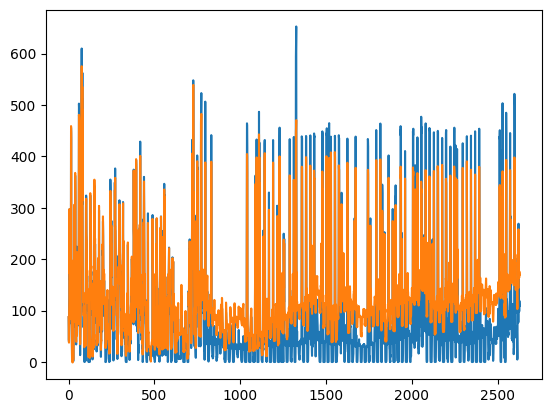

In [23]:
plt.plot(descale_labels)
plt.plot(descale_preds)